### Necessary Imports

In [26]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from optuna import Trial as trial
import optuna

### Importing Data

In [2]:
traindf=pd.read_csv("./data/train.csv")

C:\Users\krish\AppData\Local\Temp\ipykernel_18200\2170988650.py:1: DtypeWarning: Columns (4,13,14,16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  traindf=pd.read_csv("./data/train.csv")


In [3]:
testdf = pd.read_csv("./data/test.csv")

C:\Users\krish\AppData\Local\Temp\ipykernel_18200\811105806.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  testdf = pd.read_csv("./data/test.csv")


In [4]:
validationdf = pd.read_csv("./data/validation.csv")

C:\Users\krish\AppData\Local\Temp\ipykernel_18200\3722391647.py:1: DtypeWarning: Columns (13,16,36) have mixed types. Specify dtype option on import or set low_memory=False.
  validationdf = pd.read_csv("./data/validation.csv")


### Data Cleaning

In [5]:
traindf.replace('\\N', None, inplace=True)

# dropping values that are not neeeded
df=traindf.drop(['time_x', 'timetaken_in_millisec', 'fastestLap', 'rank', 'fastestLapTime', 'max_speed', 'time_y', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date'
            , 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'driver_num', 'driver_code', 'url_y'
             ,"number", "position_x", 'nationality_y', 'url', 'status', 'positionText_y', 'constructorRef', 'forename', 'surname', 'driverRef', 'positionText_x', 'nationality'], axis=1)


#converting the dob and date column into years to determine the age of the driver
df['dob'] = pd.to_datetime(df['dob'])
df['date'] = pd.to_datetime(df['date'])
df['time_difference'] = df['date'] - df['dob']
df['years'] = (df['time_difference'].dt.days / 365.25).astype(int)

df = df.drop(['dob', 'date', 'time_difference'], axis=1)

# using frequency encoding for grand_prix and company
frequency_grand_prix = df['grand_prix'].value_counts(normalize=True)
df['grand_prix_encoded'] = df['grand_prix'].map(frequency_grand_prix)

frequency_company = df['company'].value_counts(normalize=True)
df['company_encoded'] = df['company'].map(frequency_company)

df = df.drop(['grand_prix', 'company'], axis=1)


In [6]:
testdf.replace('\\N', None, inplace=True)

# dropping values that are not neeeded
df1=testdf.drop(['time_x', 'timetaken_in_millisec', 'fastestLap', 'rank', 'fastestLapTime', 'max_speed', 'time_y', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date'
            , 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'driver_num', 'driver_code', 'url_y'
             ,"number", "position_x", 'nationality_y', 'url', 'status', 'constructorRef', 'forename', 'surname', 'driverRef', 'positionText_x', 'nationality'], axis=1)


#converting the dob and date column into years to determine the age of the driver
df1['dob'] = pd.to_datetime(df1['dob'])
df1['date'] = pd.to_datetime(df1['date'])
df1['time_difference'] = df1['date'] - df1['dob']
df1['years'] = (df1['time_difference'].dt.days / 365.25).astype(int)

df1 = df1.drop(['dob', 'date', 'time_difference'], axis=1)

# using frequency encoding for grand_prix and company
frequency_grand_prix = df1['grand_prix'].value_counts(normalize=True)
df1['grand_prix_encoded'] = df1['grand_prix'].map(frequency_grand_prix)

frequency_company = df1['company'].value_counts(normalize=True)
df1['company_encoded'] = df1['company'].map(frequency_company)

df1 = df1.drop(['grand_prix', 'company'], axis=1)


C:\Users\krish\AppData\Local\Temp\ipykernel_18200\3737627441.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['dob'] = pd.to_datetime(df1['dob'])
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\3737627441.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['date'] = pd.to_datetime(df1['date'])


In [7]:
validationdf.replace('\\N', None, inplace=True)

# dropping values that are not neeeded
df2=validationdf.drop(['time_x', 'timetaken_in_millisec', 'fastestLap', 'rank', 'fastestLapTime', 'max_speed', 'time_y', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date'
            , 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'driver_num', 'driver_code', 'url_y'
             ,"number", "position_x", 'nationality_y', 'url', 'status', 'positionText_y', 'constructorRef', 'forename', 'surname', 'driverRef', 'positionText_x', 'nationality'], axis=1)


#converting the dob and date column into years to determine the age of the driver
df2['dob'] = pd.to_datetime(df2['dob'])
df2['date'] = pd.to_datetime(df2['date'])
df2['time_difference'] = df2['date'] - df2['dob']
df2['years'] = (df2['time_difference'].dt.days / 365.25).astype(int)

df2 = df2.drop(['dob', 'date', 'time_difference'], axis=1)

# using frequency encoding for grand_prix and company
frequency_grand_prix = df2['grand_prix'].value_counts(normalize=True)
df2['grand_prix_encoded'] = df2['grand_prix'].map(frequency_grand_prix)

frequency_company = df2['company'].value_counts(normalize=True)
df2['company_encoded'] = df2['company'].map(frequency_company)

df2 = df2.drop(['grand_prix', 'company'], axis=1)


### Heatmaps

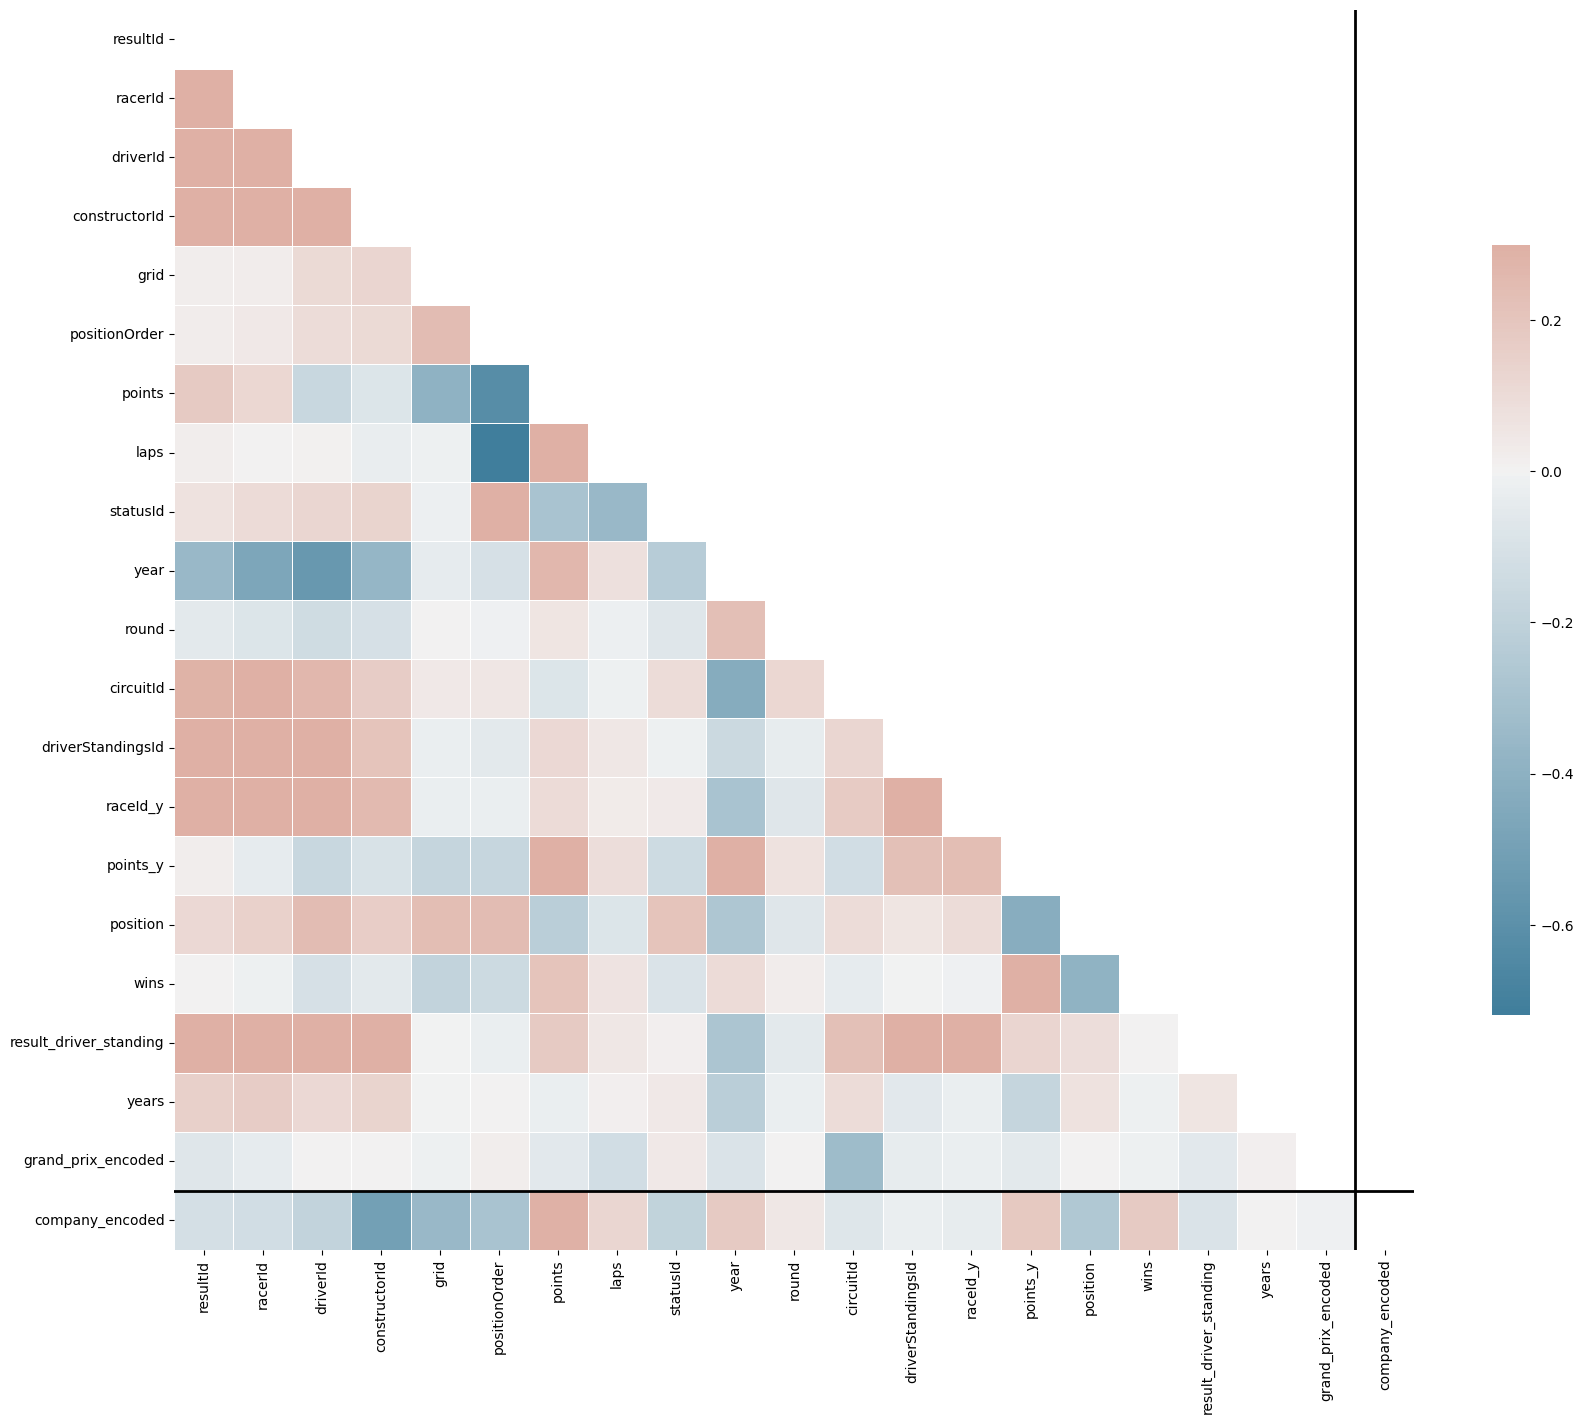

In [24]:
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize": 12})

ax.axvline(x=20, ymin=0, ymax=1, color='black', linewidth=2)
ax.axhline(y=20, xmin=0, xmax=1, color='black', linewidth=2)

Since `grand_prix_encoded` isn't helping much here as a feature, we will drop it.

In [25]:
df = df.drop(['grand_prix_encoded'], axis=1)
df1 = df1.drop(['grand_prix_encoded'], axis=1)
df2 = df2.drop(['grand_prix_encoded'], axis=1)

### Training Parameters

In [17]:
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',  # RMSE for regression
#     'num_leaves': 80,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',  # Use GPU for training
#     'gpu_platform_id': 0,  # Specify GPU platform ID (0 by default)
#     'gpu_device_id': 0  # Specify GPU device ID (0 by default)
# }

In [18]:
X_train = df.drop(columns=['position'])
y_train = df['position']

X_test = df2.drop(columns=['position'])
y_test = df2['position']

predictkardo = df1
predictkardo

resultId  racerId  driverId  constructorId  grid  positionOrder  \
0          23949      997         4              1    13              8   
1          23949      997         4              1    13              8   
2          23949      997         4              1    13              8   
3          23949      997         4              1    13              8   
4          23949      997         4              1    13              8   
...          ...      ...       ...            ...   ...            ...   
352923     26085     1110       857              1     5             20   
352924     26085     1110       857              1     5             20   
352925     26085     1110       857              1     5             20   
352926     26085     1110       857              1     5             20   
352927     26085     1110       857              1     5             20   

        points  laps  statusId  year  round  circuitId  driverStandingsId  \
0          4.0    70        11  2018      9         70              12474   
1          4.0    70        11  2018      9         70              12494   
2          4.0    70        11  2018      9         70              12514   
3          4.0    70        11  2018      9         70              12534   
4          4.0    70        11  2018      9         70              12554   
...        ...   ...       ...   ...    ...        ...                ...   
352923     0.0     0       130  2023     12         13              72085   
352924     0.0     0       130  2023     12         13              72125   
352925     0.0     0       130  2023     12         13              72145   
352926     0.0     0       130  2023     12         13              72165   
352927     0.0     0       130  2023     12         13              72186   

        raceId_y  points_y  wins  result_driver_standing  years  \
0             93      16.0     0               298739826     36   
1             94      21.0     0               299218806     36   
2             95      21.0     0               299697786     36   
3             96      25.0     0               300176766     36   
4             97      25.0     0               300655746     36   
...          ...       ...   ...                     ...    ...   
352923      1106       5.0     0              1880337225     22   
352924      1107       5.0     0              1881380625     22   
352925      1108      17.0     0              1881902325     22   
352926      1109      27.0     0              1882424025     22   
352927      1110      34.0     0              1882971810     22   

        grand_prix_encoded  company_encoded  
0                 0.051665          0.08897  
1                 0.051665          0.08897  
2                 0.051665          0.08897  
3                 0.051665          0.08897  
4                 0.051665          0.08897  
...                    ...              ...  
352923            0.056827          0.08897  
352924            0.056827          0.08897  
352925            0.056827          0.08897  
352926            0.056827          0.08897  
352927            0.056827          0.08897  

[352928 rows x 20 columns]

### Dataset Training

In [28]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the model
num_round = 2000
# bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

def objective(trial):
    # Define hyperparameter search space
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80, 300),
        'max_depth': trial.suggest_int('max_depth', 3,7, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    }

    # Set a high num_round and use early stopping
    num_round = 5000
    gbm = lgb.train(param, lgb.Dataset(X_train, label=y_train), num_round, valid_sets=[lgb.Dataset(X_test, label=y_test)])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best parameters and the best score
print(f"Best parameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

[I 2024-06-29 11:00:16,589] A new study created in memory with name: no-name-ab53e33a-c6c0-4cf2-a95d-0869f3b8f988
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\1222042887.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\1222042887.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'num_leaves': trial.suggest_int('num_leaves', 20, 80, 300),
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\1222042887.py:16: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 3,7, 15),
C:\Users\krish\AppData\Local\Temp\ipyker

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 2830101, number of used features: 20
[LightGBM] [Info] Start training from score 12.332001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[W 2024-06-29 11:03:50,625] Trial 0 failed with parameters: {'learning_rate': 0.05750259581482592, 'num_leaves': 20, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.606591026355162, 'subsample_freq': 9, 'colsample_bytree': 0.9789453978890672, 'reg_alpha': 1.4057831994471453e-07, 'reg_lambda': 6.341080501891765} because of the following error: The value None could not be cast to float..
[W 2024-06-29 11:03:50,625] Trial 0 failed with value None.
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\1222042887.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\1222042887.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'num_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 2830101, number of used features: 20
[LightGBM] [Info] Start training from score 12.332001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[W 2024-06-29 11:09:12,603] Trial 1 failed with parameters: {'learning_rate': 0.014894954132922926, 'num_leaves': 20, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.7211281431055139, 'subsample_freq': 5, 'colsample_bytree': 0.6744191861477908, 'reg_alpha': 0.1911011094665872, 'reg_lambda': 3.704407353365643e-08} because of the following error: The value None could not be cast to float..
[W 2024-06-29 11:09:12,613] Trial 1 failed with value None.
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\1222042887.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\krish\AppData\Local\Temp\ipykernel_18200\1222042887.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'nu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 2830101, number of used features: 20
[LightGBM] [Info] Start training from score 12.332001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

### Model Prediction

In [23]:
# Predict on the test set
# y_pred = bst.predict(predictkardo, num_iteration=bst.best_iteration)

# Predict on the validation set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

### Validation Dataset evaluation

In [24]:
# Evaluate the model for validation set
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 1.8320613579920244
R²: 0.9042850537733543


c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Saving model and submission.csv

In [16]:
# Optionally, save the model
# bst.save_model('lightgbm_model.txt')

# Print sample predictions
predictions_df = predictkardo.copy()
# predictions_df['actual_position'] = y_test
predictions_df['position'] = y_pred
# predictions_df
submissions = predictions_df[['position', 'result_driver_standing']]
print(submissions)
submissions.to_csv('submission.csv', index=False)
# predictions_df

         position  result_driver_standing
0        4.690201               298739826
1        4.998730               299218806
2        5.996404               299697786
3        4.773196               300176766
4        5.193063               300655746
...           ...                     ...
352923  13.830921              1880337225
352924  13.830921              1881380625
352925   8.472371              1881902325
352926   8.074246              1882424025
352927   8.407086              1882971810

[352928 rows x 2 columns]
